Transformer是一种神经网络结构，由Vaswani等人在2017年的论文“Attention Is All You Need”中提出，用于处理机器翻译、语言建模和文本生成等自然语言处理任务。

Transformer与传统NLP特征提取类模型的区别主要在以下两点：

* Transformer是一个纯基于注意力机制的结构，并将自注意力机制和多头注意力机制的概念运用到模型中；
* 由于缺少RNN模型的时序性，Transformer引入了位置编码，在数据上而非模型中添加位置信息；

以上的处理带来了几个优点：

* 更容易并行化，训练更加高效；
* 在处理长序列的任务中表现优秀，可以快速捕捉长距离中的关联信息。


## 注意力机制

如同阅读时，视线只会集中在正在阅读的部分；自然语言处理中，根据任务内容的不同，句子中需要更加关注的部分也会不同。

注意力机制便是在判断词在句子中的重要性，我们通过注意力分数来表达某个词在句子中的重要性，分数越高，说明该词对完成该任务的重要性越大。

计算注意力分数时，我们主要参考三个因素：**query**、**key**和**value**。

* query：任务内容
* key：索引/标签（帮助定位到答案）
* value：答案

如“情感分类”、“电影名字”、“中译英”等为query，每次对于任务内容的回答即为value。至于什么是key， 用一个比较直观的举例来说，每次登录视频网站搜索视频时，搜索的内容为query，搜索结果中显示的视频名称为key，它与任务内容相关，并可以引导我们至具体的视频内容（value）。

一般在文本翻译中，我们希望翻译后的句子的意思和原始句子相似，所以进行注意力分数计算时，query一般和目标序列，即翻译后的句子有关，key则与源序列，即翻译前的原始句子有关。

计算注意力分数，即为计算query与key的相似度。常用的计算注意力分数的方式有两种：additive attention和scaled dot-product attention，在这里我们主要介绍第二种方法。

在几何角度，点积（dot product）表示一个向量在另一个向量方向上的投影。换句话说，从几何角度上解读，点积代表了某个向量中的多少是和另一个向量相似的。


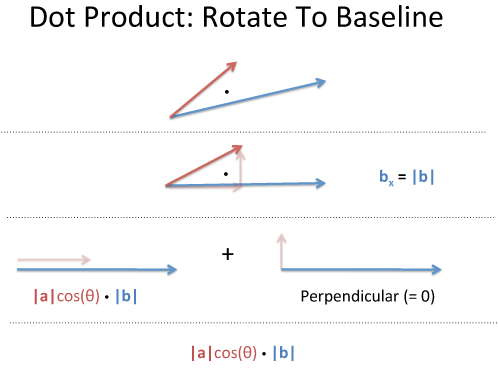

将这个概念运用到当前的情境中，我们想要求`query`和`key`之间有多少是相似的，则需要计算`query`和`key`的点积。

同时，为了避免`query`，$Q \in R^{n\times d_{model}}$  和`key` $K \in R^{m\times d_{model}}$, 本身的“大小”影响到相似度的计算，我们需要在点乘后除以 $\sqrt{d_{model}}$

$$\text{Attention Score}(Q, K)=\frac{QK^T}{\sqrt{d_{model}}}$$

我们将该相似度的区间限制与0到1之间，并令其作用在`value`上。
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_{model}}}\right)V$$

在如下代码中，我们实现了scaled dot-product attention的计算， 调用类后，返回的是加权后的value（output）以及注意力权重（attn）。




In [ ]:
import torch 
from torch import nn
from torch import optim
from torch.utils import data as Data
import numpy as np

d_model = 512 # embedding size 
max_len = 1024 # max length of sequence
d_ff = 2048 # feedforward nerual network  dimension
d_k = d_v = 64 # dimension of k(same as q) and v
n_layers = 6 # number of encoder and decoder layers
n_heads = 8 # number of heads in multihead attention
p_drop = 0.1 # propability of dropout

# d_model: Embedding的大小.
# max_len: 输入序列的最长大小.
# d_ff: 前馈神经网络的隐藏层大小, 一般是d_model的四倍.
# d_k, d_v: 自注意力中K和V的维度, Q的维度直接用K的维度代替, 因为这二者必须始终相等.
# n_layers: Encoder和Decoder的层数.
# n_heads: 自注意力多头的头数.
# p_drop: Dropout的概率.

## Scaled DotProduct Attention

In [ ]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self):
    super(ScaledDotProductAttention, self).__init__()

  def forward(self, Q, K, V, attn_mask = None):
    '''
    Q: [batch, n_heads, len_q, d_k]
    K: [batch, n_heads, len_k, d_k]
    V: [batch, n_heads, len_v, d_v]
    attn_mask: [batch, n_heads, seq_len, seq_len]
    '''
    scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # [batch, n_heads, len_q, len_k]
    if attn_mask is not None:
        scores.masked_fill_(attn_mask, -1e9)

    attn = nn.Softmax(dim=-1)(scores) # [batch, n_heads, len_q, len_k]
    prob = torch.matmul(attn, V) # [batch, n_heads, len_q, d_v]
    return prob, attn

masked_fill_能把传进来的Mask为True的地方全都填充上某个值, 这里需要用一个很大的负数来保证 , 使得其在Softmax​ 中可以被忽略.

## Mask

Mask分为两种, 一种是因为在数据中使用了padding, 不希望pad被加入到注意力中进行计算的Pad Mask for Attention, 还有一种是保证Decoder自回归信息不泄露的Subsequent Mask for Decoder.

## Pad Mask for Attention

为了方便, 假设<PAD>在字典中的Index是0, 遇到输入为0直接将其标为True.
    
在处理数据时，我们为了统一长度，会使用<pad>占位符补齐了一些稍短的文本。

"Hello world!" --> <bos> hello world ! <eos> <pad> <pad>
这些<pad>占位符没有任何意义，不应该参与注意力分数计算中。为此我们在注意力中加入了padding掩码，即识别输入序列中的<pad>占位符，保证计算时这些位置对应的注意力分数为0。

In [ ]:
def get_attn_pad_mask(seq_q, seq_k):
  '''
  Padding, because of unequal in source_len and target_len.

  parameters:
  seq_q: [batch, seq_len]
  seq_k: [batch, seq_len]

  return:
  mask: [batch, len_q, len_k]

  '''
  batch, len_q = seq_q.size()
  batch, len_k = seq_k.size()
  # we define index of PAD is 0, if tensor equals (zero) PAD tokens
  pad_attn_mask = seq_k.data.eq(0).unsqueeze(1) # [batch, 1, len_k]

  return pad_attn_mask.expand(batch, len_q, len_k) # [batch, len_q, len_k]

在Encoder和Decoder中使用Mask的情况可能各有不同:

* 在Encoder中使用Mask, 是为了将encoder_input中没有内容而打上PAD的部分进行Mask, 方便矩阵运算.

* 在Decoder中使用Mask, 可能是在Decoder的自注意力对decoder_input 的PAD进行Mask, 也有可能是对Encoder - Decoder自注意力时对encoder_input和decoder_input的PAD进行Mask


## 自注意力机制（Self-Attention）

自注意力机制中，我们关注句子本身，查看每个单词对于周边单词的重要性。这样可以很好地理清句子中的逻辑关系，如代词指代。

举个例子，在'The animal didn't cross the street because it was too tired'这句话中，'it'指代句中的'The animal'，所以自注意力会赋予'The'、'animal'更高的注意力分值。

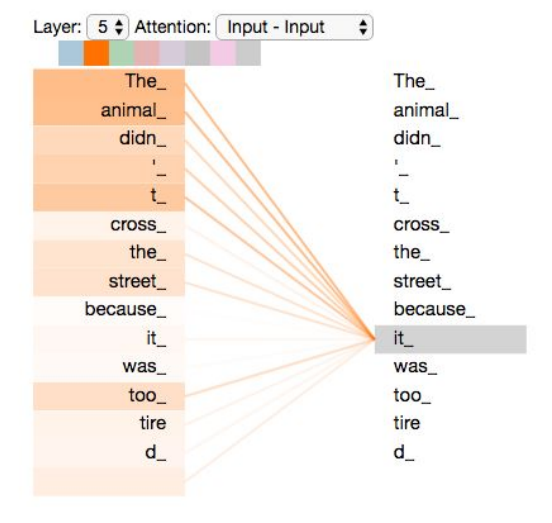

自注意力分数的计算还是遵循着上述的公式，只不过这里的`query`, `key`和`value`都变成了句子本身点乘各自权重。

给定序列$X \in \mathbb{R}^{n \times d_{model}}$, 序列长度为n，维度为$d_{model}$ 在计算自注意力时，$Q = W^QX, K = W^KX, V = W^VX$

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_{model}}}\right)V$$

其中，序列中位置为i的词与位置为j的词之间的自注意力分数为：
$$\text{Attention}(Q, K, V)_{i,j} = \frac{\text{exp}\left(\frac{Q_iK_j^T}{\sqrt{d_{model}}}\right)}{\sum_{k=1}^{n}\text{exp}\left(\frac{Q_iK_k^T}{\sqrt{d_{model}}}\right)}V_j$$


## 多头注意力（Multi-Head Attention）

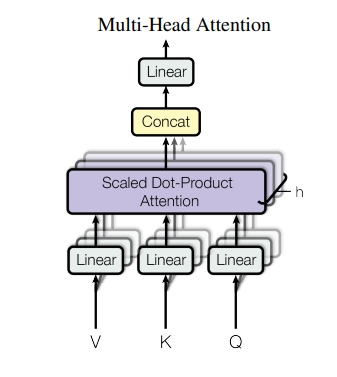

> 图片来源：Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. Attention is all you need, 2017.

多头注意力是注意力机制的扩展，它可以使模型通过不同的方式关注输入序列的不同部分，从而提升模型的训练效果。

不同于之前一次计算整体输入的注意力分数，多头注意力是多次计算，每次计算输入序列中某一部分的注意力分数，最后再将结果进行整合。

多头注意力通过对输入的embedding乘以不同的权重参数$W^{Q}$, $W^{K}$和$W^{V}$ 将其映射到多个小维度空间中，我们称之为“头”（head），每个头部会并行计算自己的自注意力分数。
$$\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i) = \text{softmax}\left(\frac{Q_iK_i^T}{\sqrt{d_{k}}}\right)V_i$$


$W^Q_i \in \mathbb{R}^{d_{model}\times d_{k}}$,$W^K_i \in \mathbb{R}^{d_{model}\times d_{k}}$和$W^V_i \in \mathbb{R}^{d_{model}\times d_{v}}$为可学习的权重参数。一般为了平衡计算成本，我们会取$d_k = d_v = d_{model} / n_{head}$ 
在获得多组自注意力分数后，我们将结果拼接到一起，得到多头注意力的最终输出。
$W^O$为可学习的权重参数，用于将拼接后的多头注意力输出映射回原来的维度。
$$\text{MultiHead}(Q, K, V)=\text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

简单来说，在多头注意力中，每个头部可以'解读'输入内容的不同方面，比如：捕捉全局依赖关系、关注特定语境下的词元、识别词和词之间的语法关系等。

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, d_model=512 , n_heads=8, dropout=0.0):
    super(MultiHeadAttention, self).__init__()
    # do not use more instance to implement multihead attention
    # it can be complete in one matrix
    self.n_heads = n_heads
    d_k = d_v = d_model// n_heads

    # we can't use bias because there is no bias term in formular
    self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
    self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
    self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
    self.fc = nn.Linear(d_v * n_heads, d_model, bias=False)
    # self.layer_norm = nn.LayerNorm(d_model).to(device)
    self.dropout = nn.Dropout(dropout)
    self.layer_norm = nn.LayerNorm(d_model)

  def forward(self, input_Q, input_K, input_V, attn_mask):
    '''
    To make sure multihead attention can be used both in encoder and decoder, 
    we use Q, K, V respectively.
    input_Q: [batch, len_q, d_model]
    input_K: [batch, len_k, d_model]
    input_V: [batch, len_v, d_model]
    '''
    residual, batch = input_Q, input_Q.size(0)

    # [batch, len_q, d_model] -- matmul W_Q --> [batch, len_q, d_q * n_heads] -- view --> 
    # [batch, len_q, n_heads, d_k,] -- transpose --> [batch, n_heads, len_q, d_k]

    Q = self.W_Q(input_Q).view(batch, -1, n_heads, d_k).transpose(1, 2) # [batch, n_heads, len_q, d_k]
    K = self.W_K(input_K).view(batch, -1, n_heads, d_k).transpose(1, 2) # [batch, n_heads, len_k, d_k]
    V = self.W_V(input_V).view(batch, -1, n_heads, d_v).transpose(1, 2) # [batch, n_heads, len_v, d_v]

    attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # [batch, n_heads, seq_len, seq_len]

    # prob: [batch, n_heads, len_q, d_v] attn: [batch, n_heads, len_q, len_k]
    prob, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)

    prob = prob.transpose(1, 2).contiguous() # [batch, len_q, n_heads, d_v]
    prob = prob.view(batch, -1, n_heads * d_v).contiguous() # [batch, len_q, n_heads * d_v]

    output = self.fc(prob) # [batch, len_q, d_model]
    output = self.dropout(output)

    return self.layer_norm(residual + output), attn

提两个非常重要的点:
在拆维度时不要破坏维度原来本身的意义. 虽然新版本已经有reshape函数可以用了, 但是仍然不要忘记, transpose后如果接permute或者view必须要加contiguous, 这是数据真实存储连续与否的问题, 请参见Pytorch之张量基础操作中的维度变换部分.

## Subsequent Mask for Decoder

该Mask是为了防止Decoder的自回归信息泄露而生的Mask, 直接生成一个上三角矩阵即可:

In [ ]:
def get_attn_subsequent_mask(seq):
  '''
  Build attention mask matrix for decoder when it autoregressing.

  parameters:
  seq: [batch, target_len]

  return:
  subsequent_mask: [batch, target_len, target_len] 
  '''
  attn_shape = [seq.size(0), seq.size(1), seq.size(1)] # [batch, target_len, target_len]
  subsequent_mask = np.triu(np.ones(attn_shape), k=1) # [batch, target_len, target_len] 
  subsequent_mask = torch.from_numpy(subsequent_mask)

  return subsequent_mask # [batch, target_len, target_len] 

其中, 用到了生成上三角的函数np.triu, 其用法为:

In [ ]:
np.triu(np.ones([3, 4]), k=1)
'''
array([[0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])
'''
np.triu(np.ones([3, 4]), k=0)
'''
array([[1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 0., 1., 1.]])
'''
np.triu(np.ones([3, 4]), k=-1)
'''
array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 1., 1., 1.]])
'''

其中k能控制上三角的大小, 越大则上三角范围越小. 与之完全相反的函数是np.tril, 能够生成下三角矩阵.

## Positional Encoding

Transformer模型不包含RNN，所以无法在模型中记录时序信息，这样会导致模型无法识别由顺序改变而产生的句子含义的改变，如“我爱我的小猫”和“我的小猫爱我”。

为了弥补这个缺陷，我们选择在输入数据中额外添加表示位置信息的位置编码。

位置编码***PE***的形状与经过word embedding后的输出***X***相同，对于索引为[pos, 2i]的元素，以及索引为[pos, 2i+1]的元素，位置编码的计算如下：

$$PE_{(pos,2i)} = \sin\Bigg(\frac{pos}{10000^{2i/d_{\text{model}}}}\Bigg)$$
$$PE_{(pos,2i+1)} = \cos\Bigg(\frac{pos}{10000^{2i/d_{\text{model}}}}\Bigg)$$

在下面的代码中，我们实现了位置编码，输入经过word embedding后的结果***X***，输出添加位置信息后的结果$X + PE$。

In [ ]:
class PositionalEncoding(nn.Module):

  def __init__(self, d_model, dropout=0.1, max_len=1024):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    positional_encoding = torch.zeros(max_len, d_model) # [max_len, d_model]
    position = torch.arange(0, max_len).float().unsqueeze(1) # [max_len, 1]

    div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                         (-torch.log(torch.Tensor([10000])) / d_model)) # [max_len / 2]

    positional_encoding[:, 0::2] = torch.sin(position * div_term) # even
    positional_encoding[:, 1::2] = torch.cos(position * div_term) # odd

    # [max_len, d_model] -> [1, max_len, d_model] -> [max_len, 1, d_model]
    positional_encoding = positional_encoding.unsqueeze(0).transpose(0, 1)

    # register pe to buffer and require no grads
    self.register_buffer('pe', positional_encoding)

  def forward(self, x):
    # x: [seq_len, batch, d_model]
    # we can add positional encoding to x directly, and ignore other dimension
    x = x + self.pe[:x.size(0), :]

    return self.dropout(x)

实现    时既可以像我写出的那样使用幂指运算, 也可以直接写出.

register_buffer能够申请一个缓冲区中的常量, 并且它不会被加入到计算图中, 也就不会参与反向传播.

更多关于register在parameter和buffer上的区别请见Pytorch模型中的parameter与buffer


## Feed Forward Neural Network

在Transformer中, Encoder或者Decoder每个Block都需要用一个前馈神经网络来添加非线性:
基于位置的前馈神经网络 （Position-Wise Feed-Forward Network）
基于位置的前馈神经网络被用来对输入中的每个位置进行非线性变换。它由两个线性层组成，层与层之间需要经过ReLU激活函数。

$\mathrm{FFN}(x) = \mathrm{ReLU}(xW_1 + b_1)W_2 + b_2$

相比固定的ReLU函数，基于位置的前馈神经网络可以处理更加复杂的关系，并且由于前馈网络是基于位置的，可以捕获到不同位置的信息，并为每个位置提供不同的转换。

注意, 这里它们都是有偏置的, 而且这两个Linear可以用两个
 的卷积来实现:

In [ ]:
class FeedForwardNetwork(nn.Module):
  '''
  Using nn.Conv1d replace nn.Linear to implements FFN.
  '''
  def __init__(self, d_model=512 , d_ff=2048 ,dropout=0.0):
    super(FeedForwardNetwork, self).__init__()
    # self.ff1 = nn.Linear(d_model, d_ff)
    # self.ff2 = nn.Linear(d_ff, d_model)
    self.ff1 = nn.Conv1d(d_model, d_ff, 1)
    self.ff2 = nn.Conv1d(d_ff, d_model, 1)
    self.relu = nn.ReLU()

    self.dropout = nn.Dropout(dropout)
    # self.layer_norm = nn.LayerNorm(d_model).to(device)
    self.layer_norm = nn.LayerNorm(d_model)

  def forward(self, x):
    # x: [batch, seq_len, d_model]
    residual = x
    x = x.transpose(1, 2) # [batch, d_model, seq_len]
    x = self.ff1(x)
    x = self.relu(x)
    x = self.ff2(x)
    x = x.transpose(1, 2) # [batch, seq_len, d_model]

    return self.layer_norm(residual + x)

#  Add：残差连接，帮助缓解网络退化问题，注意需要满足x,与 $\text{SubLayer}(x)$ 的形状一致
#  Norm：Layer Norm，层归一化，帮助模型更快地进行收敛；

作为一个子层, 不要忘记Transformer中提到的Residual Connection和Layer Norm.

我选择用两个卷积代替Linear. 在nn.Conv1d中, 要求数据的规格为[batch, x, ...], 我们是要对d_model 上的数据进行卷积, 所以还是需要transpose一下.

## Encoder and Decoder

### 编码器（Encoder）

先写出Encoder的每个Layer, 由多头注意力和FFN组成:

Transformer的Encoder负责处理输入的源序列，并将输入信息整合为一系列的上下文向量（context vector）输出。

每个encoder层中存在两个子层：多头自注意力（multi-head self-attention）和基于位置的前馈神经网络（position-wise feed-forward network）。

子层之间使用了残差连接（residual connection），并使用了层规范化（layer normalization）。二者统称为“Add & Norm”

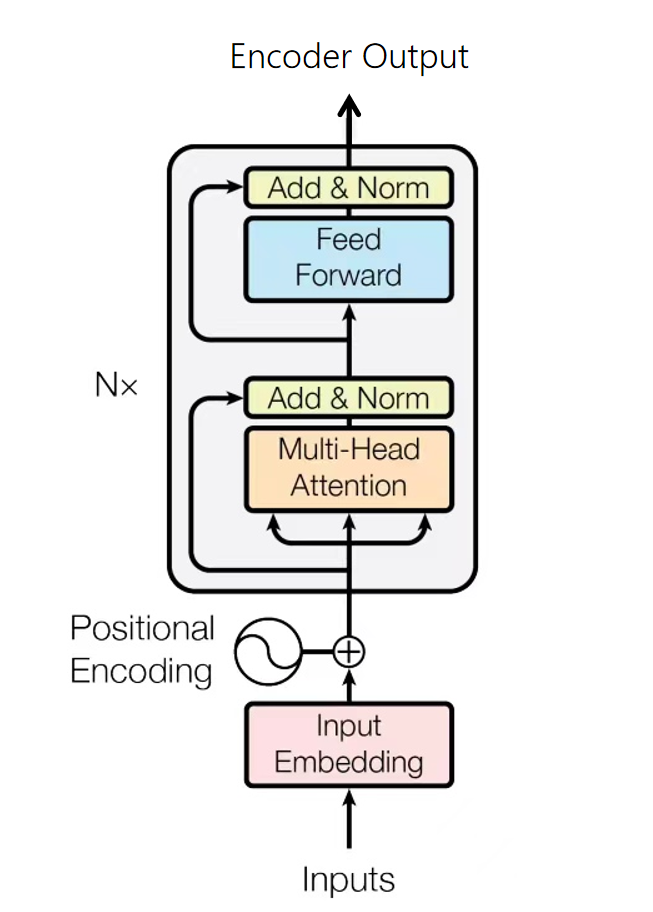



In [ ]:
class EncoderLayer(nn.Module):

  def __init__(self, d_model=512 , n_heads=8, d_ff=2048 ,dropout=0.0):
    super(EncoderLayer, self).__init__()
    self.encoder_self_attn = MultiHeadAttention(d_model, n_heads, dropout)
    self.ffn = FeedForwardNetwork(d_model, d_ff, dropout)

  def forward(self, encoder_input, encoder_pad_mask):
    '''
    encoder_input: [batch, source_len, d_model]
    encoder_pad_mask: [batch, n_heads, source_len, source_len]

    encoder_output: [batch, source_len, d_model]
    attn: [batch, n_heads, source_len, source_len]
    '''
    encoder_output, attn = self.encoder_self_attn(encoder_input, encoder_input, encoder_input, encoder_pad_mask)
    encoder_output = self.ffn(encoder_output) # [batch, source_len, d_model]

    return encoder_output, attn

对于给定的encoder_input和encoder_pad_pask, Encoder应该能够完成整个Block(Layer)的计算流程. 然后实现整个Encoder:

In [ ]:
class Encoder(nn.Module):

  def __init__(self, source_vocab_size, max_seq_len, n_layers=6, d_model=512, n_heads=8, d_ff=2048, dropout=0.0):
    super(Encoder, self).__init__()
    self.source_embedding = nn.Embedding(source_vocab_size, d_model)
    self.positional_embedding = PositionalEncoding(d_model, max_len=max_seq_len)
    self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for layer in range(n_layers)])

  def forward(self, encoder_input):
    # encoder_input: [batch, source_len]
    encoder_output = self.source_embedding(encoder_input) # [batch, source_len, d_model]
    encoder_output = self.positional_embedding(encoder_output.transpose(0, 1)).transpose(0, 1) # [batch, source_len, d_model]

    encoder_self_attn_mask = get_attn_pad_mask(encoder_input, encoder_input) # [batch, source_len, source_len]
    encoder_self_attns = list()
    for layer in self.layers:
      # encoder_output: [batch, source_len, d_model]
      # encoder_self_attn: [batch, n_heads, source_len, source_len]
      encoder_output, encoder_self_attn = layer(encoder_output, encoder_self_attn_mask)
      encoder_self_attns.append(encoder_self_attn)

    return encoder_output, encoder_self_attns

对于整个Encoder, 直接将Token的Index传入Embedding中, 再添入位置编码, 之后就经过多层Transformer Encoder. 在传入Block前, 先需要计算Padding的Mask, 再将上层的输出作为下层输入依次迭代.

### 解码器 （Decoder）

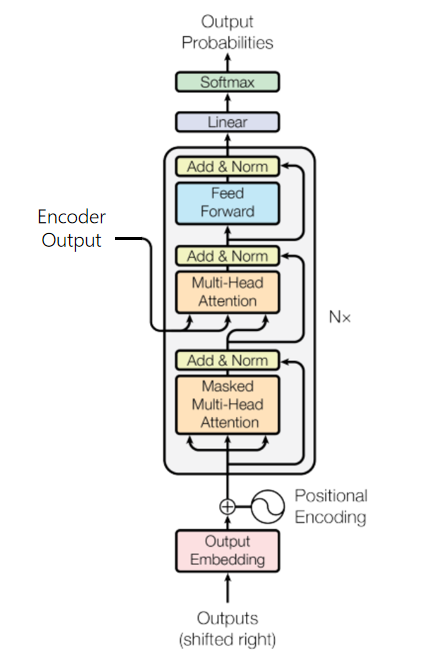

解码器将编码器输出的上下文序列转换为目标序列的预测结果$\hat{Y}$，该输出将在模型训练中与真实目标输出`Y`进行比较，计算损失。

不同于编码器，每个Decoder层中包含两层多头注意力机制,并在最后多出一个线性层，输出对目标序列的预测结果。

* 第一层：计算目标序列的注意力分数的**掩码多头自注意力**；
* 第二层：用于计算上下文序列与目标序列对应关系，其中Decoder掩码多头注意力的输出作为query，Encoder的输出（上下文序列）作为key和value；

带掩码的多头注意力
在处理目标序列的输入时，t时刻的模型只能“观察”直到t-1时刻的所有词元，后续的词语不应该一并输入Decoder中。

为了保证在t时刻，只有t-1个词元作为输入参与多头注意力分数的计算，我们需要在第一个多头注意力中额外增加一个时间掩码，使目标序列中的词随时间发展逐个被暴露出来。

该注意力掩码可通过三角矩阵实现，对角线以上的词元表示为不参与注意力计算的词元，标记为1。

$\begin{matrix}
0 & 1 & 1 & 1 & 1\\
0 & 0 & 1 & 1 & 1\\
0 & 0 & 0 & 1 & 1\\
0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0\\
\end{matrix}$

该掩码一般被称作subsequent mask。

最后，将subsequent mask和padding mask合并为一个整体的掩码，确保模型既不会注意到t时刻以后的词元，也不会关注为<pad>的词元。

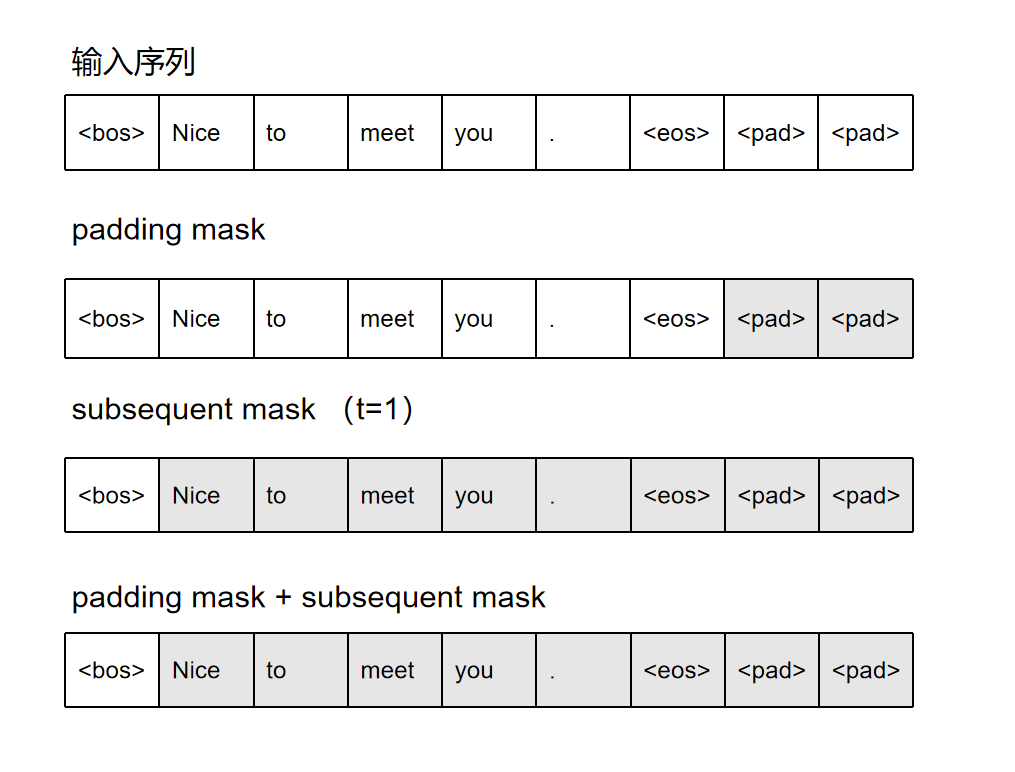

其实实现了Encoder, Decoder的实现部分都是对应的. 先实现Decoder的Block:

In [ ]:
class DecoderLayer(nn.Module):

  def __init__(self, d_model=512 , n_heads=8, d_ff=2048 ,dropout=0.0):
    super(DecoderLayer, self).__init__()
    self.decoder_self_attn = MultiHeadAttention(d_model, n_heads, dropout)
    self.encoder_decoder_attn = MultiHeadAttention(d_model , n_heads, dropout)
    self.ffn = FeedForwardNetwork(d_model, d_ff, dropout)

  def forward(self, decoder_input, encoder_output, decoder_self_mask, decoder_encoder_mask):
    '''
    decoder_input: [batch, target_len, d_mdoel]
    encoder_output: [batch, source_len, d_model]
    decoder_self_mask: [batch, target_len, target_len]
    decoder_encoder_mask: [batch, target_len, source_len]
    '''
    # masked mutlihead attention
    # Q, K, V all from decoder it self
    # decoder_output: [batch, target_len, d_model]
    # decoder_self_attn: [batch, n_heads, target_len, target_len]
    decoder_output, decoder_self_attn = self.decoder_self_attn(decoder_input, decoder_input, decoder_input, decoder_self_mask)

    # Q from decoder, K, V from encoder
    # decoder_output: [batch, target_len, d_model]
    # decoder_encoder_attn: [batch, n_heads, target_len, source_len]
    decoder_output, decoder_encoder_attn = self.encoder_decoder_attn(decoder_output, encoder_output, encoder_output, decoder_encoder_mask)
    decoder_output = self.ffn(decoder_output) # [batch, target_len, d_model]

    return decoder_output, decoder_self_attn, decoder_encoder_attn

与Encoder相对应, 只不过因为多了一个Encoder - Decoder自注意力, 所以需要额外计算一个Encoder - Decoder的Mask. 然后写出整个Decoder:

In [ ]:
class Decoder(nn.Module):

  def __init__(self, target_vocab_size, max_seq_len, n_layers=6, d_model=512, n_heads=8, d_ff=2048, dropout=0.0):
    super(Decoder, self).__init__()
    self.target_embedding = nn.Embedding(target_vocab_size, d_model)
    self.positional_embedding = PositionalEncoding(d_model, max_len=max_seq_len)
    self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for layer in range(n_layers)])

  def forward(self, decoder_input, encoder_input, encoder_output):
    '''
    decoder_input: [batch, target_len]
    encoder_input: [batch, source_len]
    encoder_output: [batch, source_len, d_model]
    '''
    decoder_output = self.target_embedding(decoder_input) # [batch, target_len, d_model]
    decoder_output = self.positional_embedding(decoder_output.transpose(0, 1)).transpose(0, 1).to(device) # [batch, target_len, d_model]
    decoder_self_attn_mask = get_attn_pad_mask(decoder_input, decoder_input).to(device) # [batch, target_len, target_len]
    decoder_subsequent_mask = get_attn_subsequent_mask(decoder_input).to(device) # [batch, target_len, target_len]

    decoder_encoder_attn_mask = get_attn_pad_mask(decoder_input, encoder_input) # [batch, target_len, source_len]

    decoder_self_mask = torch.gt(decoder_self_attn_mask + decoder_subsequent_mask, 0).to(device)
    decoder_self_attns, decoder_encoder_attns = [], []

    for layer in self.layers:
      # decoder_output: [batch, target_len, d_model]
      # decoder_self_attn: [batch, n_heads, target_len, target_len]
      # decoder_encoder_attn: [batch, n_heads, target_len, source_len]
      decoder_output, decoder_self_attn, decoder_encoder_attn = layer(decoder_output, encoder_output, decoder_self_mask, decoder_encoder_attn_mask)
      decoder_self_attns.append(decoder_self_attn)
      decoder_encoder_attns.append(decoder_encoder_attn)

    return decoder_output, decoder_self_attns, decoder_encoder_attns

和Encoder相对应, 但Decoder和Encoder使用了两个不同的Embedding. 对于Mask, 可以把自回归Mask和Padding Mask用torch.gt整合成一个Mask, 送入其中.

## Transformer 结构


Transformer同样是encoder-decoder的结构，只不过这里的“encoder”和“decoder”是由无数个同样结构的encoder层和decoder层堆叠组成。

在进行机器翻译时，encoder解读源语句（被翻译的句子）的信息，并传输给decoder。decoder接收源语句信息后，结合当前输入（目前翻译的情况），预测下一个单词，直到生成完整的句子。

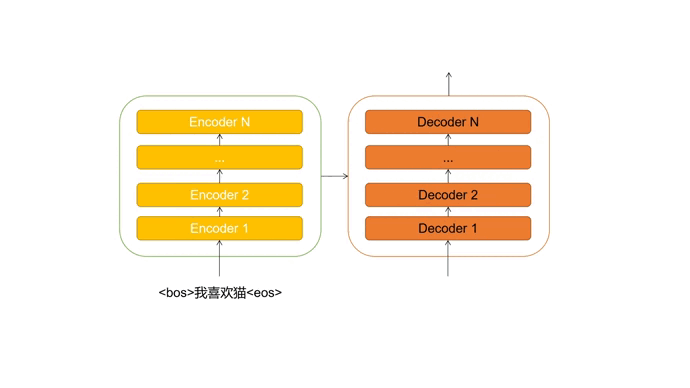


Transformer的具体结构如下图所示，在进入encoder或decoder前，源序列和目标序列需要经过一些“加工”。

* word embedding: 将序列转换为模型所能理解的词向量表示，其中包含了序列的内容信息。
* positional encoding：在内容信息的基础上添加位置信息。

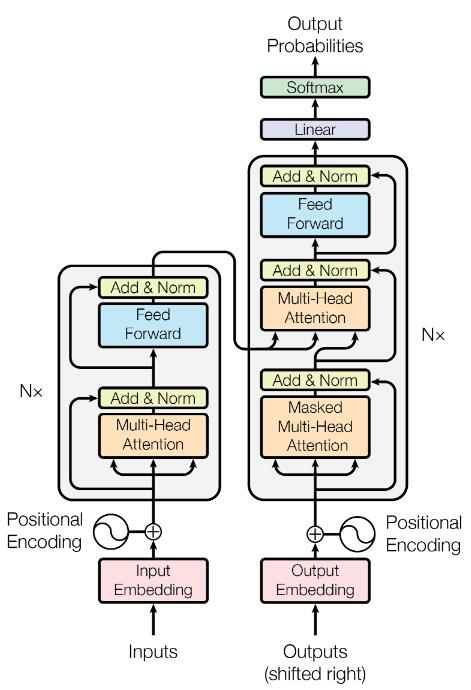


In [ ]:
class Transformer(nn.Module):

  def __init__(self, src_vocab_size, src_max_len, tgt_vocab_size, tgt_max_len, n_layers=6, d_model=512, n_heads=8, d_ff=2048, dropout=0.2):
    super(Transformer, self).__init__()

    self.encoder = Encoder(src_vocab_size, src_max_len, n_layers, d_model, n_heads, d_ff, dropout).to(device)
    self.decoder = Decoder(tgt_vocab_size, tgt_max_len, n_layers, d_model, n_heads, d_ff, dropout).to(device)
    self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False).to(device)
    # self.softmax = nn.Softmax(dim=2)

  def forward(self, encoder_input, decoder_input):
    '''
    encoder_input: [batch, source_len]
    decoder_input: [batch, target_len]
    '''
    # encoder_output: [batch, source_len, d_model]
    # encoder_attns: [n_layers, batch, n_heads, source_len, source_len]
    encoder_output, encoder_attns = self.encoder(encoder_input)
    # decoder_output: [batch, target_len, d_model]
    # decoder_self_attns: [n_layers, batch, n_heads, target_len, target_len]
    # decoder_encoder_attns: [n_layers, batch, n_heads, target_len, source_len]
    decoder_output, decoder_self_attns, decoder_encoder_attns = self.decoder(decoder_input, encoder_input, encoder_output)
    decoder_logits = self.projection(decoder_output) # [batch, target_len, target_vocab_size]

    # decoder_logits: [batch * target_len, target_vocab_size]
    # output = self.softmax(decoder_logits)
    # output = self.softmax(decoder_logits.view(-1, decoder_logits.size(-1)))
    return decoder_logits.view(-1, decoder_logits.size(-1)), encoder_attns, decoder_self_attns, decoder_encoder_attns
    # return output, encoder_attns, decoder_self_attns, decoder_encoder_attns


最后对logits的处理是view成了[batch * target_len, target_vocab_size], 前面的大小并不影响我们一会用交叉熵计算损失.

## 通过Transformer实现文本机器翻译

全流程

* 数据预处理： 将图像、文本等数据处理为可以计算的Tensor
* 模型构建： 使用框架API， 搭建模型
* 模型训练： 定义模型训练逻辑， 遍历训练集进行训练
* 模型评估： 使用训练好的模型， 在测试集评估效果
* 模型推理： 将训练好的模型部署， 输入新数据获得预测结果

### 数据准备

我们本次使用的数据集为Multi30K数据集，它是一个大规模的图像-文本数据集，包含30K+图片，每张图片对应两类不同的文本描述：

* 英语描述，及对应的德语翻译；
* 五个独立的、非翻译而来的英语和德语描述，描述中包含的细节并不相同；

因其收集的不同语言对于图片的描述相互独立，所以训练出的模型可以更好地适用于有噪声的多模态内容。

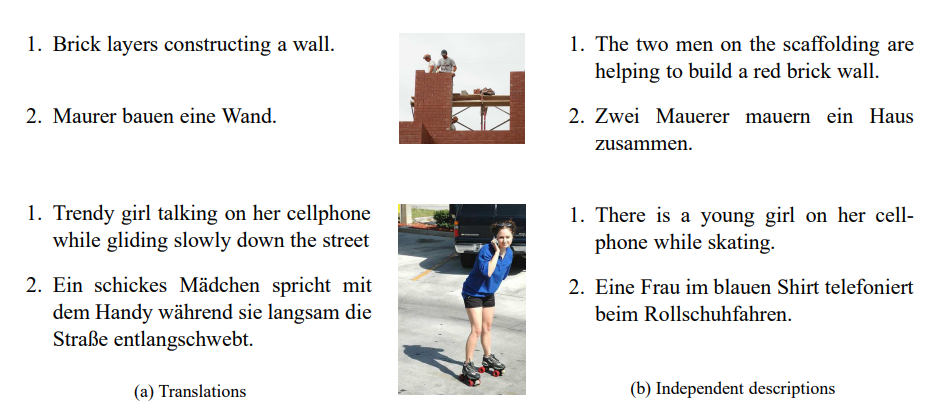

在本次文本翻译任务中，德语是源语言（source languag），英语是目标语言（target language）。

### 数据下载模块
使用download进行数据下载，并将tar.gz文件解压到指定文件夹。

In [ ]:
from download import download
from pathlib import Path
from tqdm import tqdm
import os

urls = {
    'train': 'http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/training.tar.gz',
    'valid': 'http://www.quest.dcs.shef.ac.uk/wmt16_files_mmt/validation.tar.gz',
    'test': 'http://www.quest.dcs.shef.ac.uk/wmt17_files_mmt/mmt_task1_test2016.tar.gz'
}

cache_dir = Path.home() / '.mindspore_examples'

train_path = download(urls['train'], os.path.join(cache_dir, 'train'), kind='tar.gz')
valid_path = download(urls['valid'], os.path.join(cache_dir, 'valid'), kind='tar.gz')
test_path = download(urls['test'], os.path.join(cache_dir, 'test'), kind='tar.gz')

### 数据预处理
在使用数据进行模型训练等操作时，我们需要对数据进行预处理，流程如下：

1. 加载数据集；
2. 构建词典；
3. 创建数据迭代器；

数据加载器

加载数据集，并进行分词，即将句子拆解为单独的词元（token，可以为字符或者单词）。一般在机器翻译类任务中，我们习惯进行单词级词元化，即每个词元要么为一个单词，要么为一个标点符号。同一个单词，不论首字母是否大写，都应该对应同一个词元，故在分词前，我们需统一将单词转换为小写。

"Hello world!" --> ["hello", "world", "!"]
接下来，我们创建数据加载器Multi30K。后期调用该类进行遍历时，每次返回当前源语言（德语）与目标语言（英语）文本描述的词元列表。

In [ ]:
import re

class Multi30K():
    """Multi30K数据集加载器
    
    加载Multi30K数据集并处理为一个Python迭代对象。
    
    """
    def __init__(self, path):
        self.data = self._load(path)
        
    def _load(self, path):
        def tokenize(text):
            text = text.rstrip()
            return [tok.lower() for tok in re.findall(r'\w+|[^\w\s]', text)]
        
        members = {i.split('.')[-1]: i for i in os.listdir(path)}
        de_path = os.path.join(path, members['de'])
        en_path = os.path.join(path, members['en'])
        with open(de_path, 'r', encoding='utf-8') as de_file:
            de = de_file.readlines()[:-1]
            de = [tokenize(i) for i in de]
        with open(en_path, 'r', encoding='utf-8') as en_file:
            en = en_file.readlines()[:-1]
            en = [tokenize(i) for i in en]

        return list(zip(de, en))
        
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset, valid_dataset, test_dataset = Multi30K(train_path), Multi30K(valid_path), Multi30K(test_path)

对解压和分词结果进行测试，打印测试数据集第一组英德语文本，可以看到每一个单词和标点符号已经被单独分离出来。

In [ ]:
for de, en in test_dataset:
    print(f'de = {de}')
    print(f'en = {en}')
    break

词典
将每个词元映射到从0开始的数字索引中（为节约存储空间，可过滤掉词频低的词元），词元和数字索引所构成的集合叫做词典（vocabulary）。

以上述“Hello world!”为例，该序列组成的词典为：

{"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3, "hello": 4, "world": 5, "!": 6}
在构建词典中，我们使用了4个特殊词元。

* <unk>：未知词元（unknown），将出现次数少于一定频率的单词统一判定为未知词元；
* <bos>：起始词元（begin of sentence），用来标注一个句子的开始；
* <eos>：结束词元（end of sentence），用来标注一个句子的结束；
* <pad>：填充词元（padding），当句子长度不够时将句子填充至统一长度；
通过Vocab创建词典后，我们可以实现词元与数字索引之间的互相转换。我们可以通过调用enocde函数，返回输入词元或者词元序列对应的数字索引或数字索引序列，反之亦然，我们同样可以通过调用decode函数，返回输入数字索引或数字索引序列对应的词元或词元序列。

In [ ]:
class Vocab:
    """通过词频字典，构建词典"""

    special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>']

    def __init__(self, word_count_dict, min_freq=1):
        self.word2idx = {}
        for idx, tok in enumerate(self.special_tokens):
            self.word2idx[tok] = idx

        filted_dict = {
            w: c
            for w, c in word_count_dict.items() if c >= min_freq
        }
        for w, _ in filted_dict.items():
            self.word2idx[w] = len(self.word2idx)

        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        self.bos_idx = self.word2idx['<bos>']
        self.eos_idx = self.word2idx['<eos>']
        self.pad_idx = self.word2idx['<pad>']
        self.unk_idx = self.word2idx['<unk>']

    def _word2idx(self, word):
        """单词映射至数字索引"""
        if word not in self.word2idx:
            return self.unk_idx
        return self.word2idx[word]

    def _idx2word(self, idx):
        """数字索引映射至单词"""
        if idx not in self.idx2word:
            raise ValueError('input index is not in vocabulary.')
        return self.idx2word[idx]

    def encode(self, word_or_list):
        """将单个单词或单词数组映射至单个数字索引或数字索引数组"""
        if isinstance(word_or_list, list):
            return [self._word2idx(i) for i in word_or_list]
        return self._word2idx(word_or_list)

    def decode(self, idx_or_list):
        """将单个数字索引或数字索引数组映射至单个单词或单词数组"""
        if isinstance(idx_or_list, list):
            return [self._idx2word(i) for i in idx_or_list]
        return self._idx2word(idx_or_list)

    def __len__(self):
        return len(self.word2idx)

通过自定义词频字典进行测试，我们可以看到词典已去除词频少于2的词元c，并加入了默认的四个特殊占位符，故词典整体长度为：4 - 1 + 4 = 7

In [ ]:
word_count = {'a':20, 'b':10, 'c':1, 'd':2}

vocab = Vocab(word_count, min_freq=2)
len(vocab)

使用collections中的Counter和OrderedDict统计英/德语每个单词在整体文本中出现的频率。构建词频字典，然后再将词频字典转为词典。其中，收录所有源语言（德语）词元的词典为de_vocab，收录所有目标语言（英语）词元的词典为en_vocab。

在分配数字索引时有一个小技巧：常用的词元对应数值较小的索引，这样可以节约空间。

In [ ]:
from collections import Counter, OrderedDict

def build_vocab(dataset):
    de_words, en_words = [], []
    for de, en in dataset:
        de_words.extend(de)
        en_words.extend(en)

    de_count_dict = OrderedDict(sorted(Counter(de_words).items(), key=lambda t: t[1], reverse=True))
    en_count_dict = OrderedDict(sorted(Counter(en_words).items(), key=lambda t: t[1], reverse=True))

    return Vocab(de_count_dict, min_freq=2), Vocab(en_count_dict, min_freq=2)

In [ ]:
de_vocab, en_vocab = build_vocab(train_dataset)
print('Unique tokens in de vocabulary:', len(de_vocab))

数据迭代器
数据预处理的最后一步是创建数据迭代器。截至目前，我们已经通过数据加载器Multi30K将源语言（德语）与目标语言（英语）的文本描述转换为词元序列，并构建了词元与数字索引一一对应的词典，接下来，需要将词元序列转换为数字索引序列。

还是以“Hello world!”为例，我们逐步演示数据迭代器中的操作

我们将表示开始和结束的特殊词元<bos>和<eos>分别添加在每个词元序列的句首和句尾。
["hello", "world", "!"] --> ["<bos>", "hello", "world", "!", "<eos>"]
统一序列长度（超出长度的进行截断，未达到长度的通过填充<pad>进行补齐）,同时记录序列的有效长度。此处假定统一的长度为7。
["<bos>", "hello", "world", "!", "<eos>"] --> ["<bos>", "hello", "world", "!", "<eos>", "<pad>", "<pad>"]， valid length = 5
最后，对文本序列进行批处理。对于每个batch中的序列，通过调用词典中的encode为序列中的所有词元找到其对应的数字索引，将结果以Tensor的形式返回。
["<bos>", "hello", "world", "!", "<eos>", "<pad>", "<pad>"] --> [2, 4, 5, 6, 3, 1, 1] --> tensor

In [ ]:

class Iterator():
    """创建数据迭代器"""
    def __init__(self, dataset, de_vocab, en_vocab, batch_size, max_len=32, drop_reminder=False):
        self.dataset = dataset
        self.de_vocab = de_vocab
        self.en_vocab = en_vocab

        self.batch_size = batch_size
        self.max_len = max_len
        self.drop_reminder = drop_reminder

        length = len(self.dataset) // batch_size
        self.len = length if drop_reminder else length + 1  # 批量数量

    def __call__(self):
        def pad(idx_list, vocab, max_len):
            """统一序列长度，并记录有效长度"""
            idx_pad_list, idx_len = [], []
            for i in idx_list:
                if len(i) > max_len - 2:
                    idx_pad_list.append(
                        [vocab.bos_idx] + i[:max_len-2] + [vocab.eos_idx]
                    )
                    idx_len.append(max_len)
                else:
                    idx_pad_list.append(
                        [vocab.bos_idx] + i + [vocab.eos_idx] + [vocab.pad_idx] * (max_len - len(i) - 2)
                    )
                    idx_len.append(len(i) + 2)
            return idx_pad_list, idx_len

        def sort_by_length(src, trg):
            """对德/英语的字段长度进行排序"""
            data = zip(src, trg)
            data = sorted(data, key=lambda t: len(t[0]), reverse=True)
            return zip(*list(data))

        def encode_and_pad(batch_data, max_len):
            """将批量中的文本数据转换为数字索引，并统一每个序列的长度"""
            src_data, trg_data = zip(*batch_data)
            src_idx = [self.de_vocab.encode(i) for i in src_data]
            trg_idx = [self.en_vocab.encode(i) for i in trg_data]

            src_idx, trg_idx = sort_by_length(src_idx, trg_idx)
            src_idx_pad, src_len = pad(src_idx, de_vocab, max_len)
            trg_idx_pad, _ = pad(trg_idx, en_vocab, max_len)

            return src_idx_pad, src_len, trg_idx_pad

        for i in range(self.len):
            if i == self.len - 1 and not self.drop_reminder:
                batch_data = self.dataset[i * self.batch_size:]
            else:
                batch_data = self.dataset[i * self.batch_size: (i+1) * self.batch_size]

            src_idx, src_len, trg_idx = encode_and_pad(batch_data, self.max_len)
            yield mindspore.Tensor(src_idx, mindspore.int32), \
                mindspore.Tensor(src_len, mindspore.int32), \
                mindspore.Tensor(trg_idx, mindspore.int32)

    def __len__(self):
        return self.len

In [ ]:
train_iterator = Iterator(train_dataset, de_vocab, en_vocab, batch_size=128, max_len=32, drop_reminder=True)
valid_iterator = Iterator(valid_dataset, de_vocab, en_vocab, batch_size=128, max_len=32, drop_reminder=False)
test_iterator = Iterator(test_dataset, de_vocab, en_vocab, batch_size=1, max_len=32, drop_reminder=False)

模型构建
定义超参数，实例化模型。

In [ ]:
src_vocab_size = len(de_vocab)
trg_vocab_size = len(en_vocab)
src_pad_idx = de_vocab.pad_idx
trg_pad_idx = en_vocab.pad_idx

d_model = 512
d_ff = 2048
n_layers = 6
n_heads = 8

encoder = Encoder(src_vocab_size, d_model, n_heads, d_ff, n_layers, dropout_p=0.1)
decoder = Decoder(trg_vocab_size, d_model, n_heads, d_ff, n_layers, dropout_p=0.1)
model = Transformer(encoder, decoder)

模型训练 & 模型评估
定义损失函数与优化器。

损失函数：定义如何计算模型输出(logits)与目标(targets)之间的误差，这里可以使用交叉熵损失（CrossEntropyLoss）
优化器：MindSpore将模型优化算法的实现称为优化器。优化器内部定义了模型的参数优化过程（即梯度如何更新至模型参数），所有优化逻辑都封装在优化器对象中。

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)
optimizer = nn.Adam(model.trainable_params(), learning_rate=0.0001)

模型训练逻辑

* Network+loss function直接构造正向函数
* 函数变换，获得梯度计算（反向传播）函数
* 构造训练过程函数
* 调用函数进行训练

定义前向网络计算逻辑。

在训练过程中，表示句子结尾的<eos>占位符应是被模型预测出来，而不是作为模型的输入，所以在处理Decoder的输入时，我们需要移除目标序列最末的<eos>占位符。
$\text{trg} = [\text{<bos>}, x_1, x_2, ..., x_n, \text{<eos>}]$
$\text{trg[:-1]} = [\text{<bos>}, x_1, x_2, ..., x_n]$

其中，$x_i$代表目标序列中第i个表示实际内容的词元。
    
我们期望最终的输出包含表示句末的<eos>，不包含表示句首的<bos>，所以在计算损失时，需要同样去除的目标序列的句首<bos>占位符，再进行比较。
    
$\text{output} = [y_1, y_2, ..., y_n, \text{<eos>}]$
    
$\text{trg[1:]} = [x_1, x_2, ..., x_n, \text{<bos>}]$
    
其中，$y_i$表示预测的第i个实际内容词元。
    
定义梯度计算函数。

为了优化模型参数，需要求参数对loss的导数。我们调用mindspore.ops.value_and_grad函数，来获得function的微分函数。
    
定义训练一个step的逻辑。

In [ ]:
def train_step(enc_inputs, dec_inputs):
    loss, grads = grad_fn(enc_inputs, dec_inputs)
    optimizer(grads)
    return loss

定义整体训练逻辑。

在训练中，模型会以最小化损失为目标更新模型权重，故模型状态需设置为训练model.set_train(True)。

In [ ]:
def train(iterator, epoch=0):
    model.set_train(True)
    num_batches = len(iterator)
    total_loss = 0
    total_steps = 0

    with tqdm(total=num_batches) as t:
        t.set_description(f'Epoch: {epoch}')
        for src, src_len, trg in iterator():
            loss = train_step(src, trg)
            total_loss += loss.asnumpy()
            total_steps += 1
            curr_loss = total_loss / total_steps
            t.set_postfix({'loss': f'{curr_loss:.2f}'})
            t.update(1)

    return total_loss / total_steps

In [ ]:
定义模型评估逻辑。

在评估中，仅需正向计算loss，无需更新模型参数,故模型状态需设置为训练model.set_train(False)。

In [ ]:
def evaluate(iterator):
    model.set_train(False)
    num_batches = len(iterator)
    total_loss = 0
    total_steps = 0

    with tqdm(total=num_batches) as t:
        for src, _, trg in iterator():
            loss = forward(src, trg)
            total_loss += loss.asnumpy()
            total_steps += 1
            curr_loss = total_loss / total_steps
            t.set_postfix({'loss': f'{curr_loss:.2f}'})
            t.update(1)

    return total_loss / total_steps

模型训练
数据集遍历迭代，一次完整的数据集遍历成为一个epoch。我们逐个epoch打印训练的损失值和评估精度，并通过save_checkpoint保存评估精度最高的ckpt文件（transformer.ckpt）到home_path/.mindspore_examples/transformer.ckpt。

In [ ]:
from mindspore import save_checkpoint

num_epochs = 10
best_valid_loss = float('inf')
ckpt_file_name = os.path.join(cache_dir, 'transformer.ckpt')


for i in range(num_epochs):
    train_loss = train(train_iterator, i)
    valid_loss = evaluate(valid_iterator)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_checkpoint(model, ckpt_file_name)

模型推理

首先，通过load_checkpoint与load_param_into_net将训练好的模型参数加载入新实例化的模型中。

In [ ]:
from mindspore import load_checkpoint, load_param_into_net

encoder = Encoder(src_vocab_size, d_model, n_heads, d_ff, n_layers, dropout_p=0.1)
decoder = Decoder(trg_vocab_size, d_model, n_heads, d_ff, n_layers, dropout_p=0.1)
new_model = Transformer(encoder, decoder)

param_dict = load_checkpoint(ckpt_file_name)
load_param_into_net(new_model, param_dict)

推理过程中无需对模型参数进行更新，所以这里model.set_train(False)。

我们输入一个德文语句，期望可以返回翻译好的英文语句。

首先通过Encoder提取德文序列中的特征信息，并将其传输至Decoder。

Decoder最开始的输入为起始占位符<bos>，每次会根据输入预测下一个出现的单词，并对输入进行更新，直到预测出终止占位符<eos>。
   
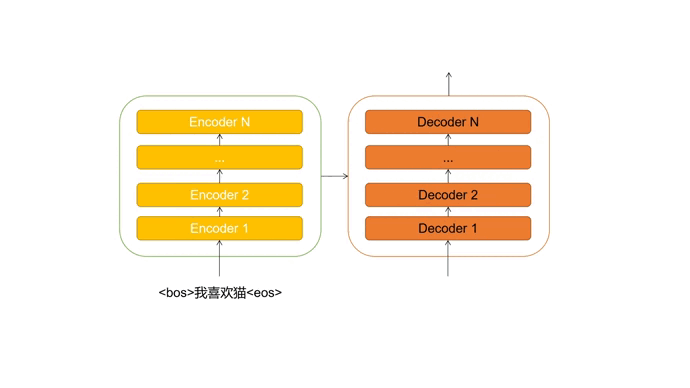

In [ ]:
def inference(sentence, max_len=32):
    """模型推理：输入一个德语句子，输出翻译后的英文句子
    enc_inputs: [batch_size(1), src_len]
    """
    new_model.set_train(False)

    if isinstance(sentence, str):
        tokens = [tok.lower() for tok in re.findall(r'\w+|[^\w\s]', sentence.rstrip())]
    else:
        tokens = [token.lower() for token in sentence]

    if len(tokens) > max_len - 2:
        src_len = max_len
        tokens = ['<bos>'] + tokens[:max_len - 2] + ['<eos>']
    else:
        src_len = len(tokens) + 2
        tokens = ['<bos>'] + tokens + ['<eos>'] + ['<pad>'] * (max_len - src_len)

    indexes = de_vocab.encode(tokens)
    enc_inputs = Tensor(indexes, mstype.float32).expand_dims(0)

    enc_outputs, _ = new_model.encoder(enc_inputs, src_pad_idx)

    dec_inputs = Tensor([[en_vocab.bos_idx]], mstype.float32)

    max_len = enc_inputs.shape[1]
    for _ in range(max_len):
        dec_outputs, _, _ = new_model.decoder(dec_inputs, enc_inputs, enc_outputs, src_pad_idx, trg_pad_idx)
        dec_logits = dec_outputs.view((-1, dec_outputs.shape[-1]))

        dec_logits = dec_logits[-1, :]
        pred = dec_logits.argmax(axis=0).expand_dims(0).expand_dims(0)
        pred = pred.astype(mstype.float32)

        dec_inputs = ops.concat((dec_inputs, pred), axis=1)

        if int(pred.asnumpy()[0]) == en_vocab.eos_idx:
            break

    trg_indexes = [int(i) for i in dec_inputs.view(-1).asnumpy()]
    eos_idx = trg_indexes.index(en_vocab.eos_idx) if en_vocab.eos_idx in trg_indexes else -1
    trg_tokens = en_vocab.decode(trg_indexes[1:eos_idx])

    return trg_tokens

以测试数据集中的第一组语句为例，进行测试。

In [ ]:
example_idx = 0

src = test_dataset[example_idx][0]
trg = test_dataset[example_idx][1]
pred_trg = inference(src)

print(f'src = {src}')
print(f'trg = {trg}')
print(f"predicted trg = {pred_trg}")

BLEU得分

双语替换评测得分（bilingual evaluation understudy，BLEU）为衡量文本翻译模型生成出来的语句好坏的一种算法，它的核心在于评估机器翻译的译文$\text{pred}$ 与人工翻译的参考译文 $\text{label}$ 的相似度。通过对机器译文的片段与参考译文进行比较，计算出各个片段的的分数，并配以权重进行加和，基本规则为：

1. 惩罚过短的预测，即如果机器翻译出来的译文相对于人工翻译的参考译文过于短小，则命中率越高，需要施加更多的惩罚；
2. 对长段落匹配更高的权重，即如果出现长段落的完全命中，说明机器翻译的译文更贴近人工翻译的参考译文；

BLEU的公式如下：
$$exp(min(0, 1-\frac{len(\text{label})}{len(\text{pred})})\Pi^k_{n=1}p_n^{1/2^n})$$

* len(label)：人工翻译的译文长度
* len(pred)：机器翻译的译文长度
* p_n：n-gram的精度
我们可以调用nltk中的corpus_bleu函数来计算BLEU，在此之前，需要手动下载nltk。


In [ ]:
pip install nltk

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(dataset, max_len=50):
    trgs = []
    pred_trgs = []
    
    for data in dataset[:10]:
        
        src = data[0]
        trg = data[1]

        pred_trg = inference(src, max_len)
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return corpus_bleu(trgs, pred_trgs)

bleu_score = calculate_bleu(test_dataset)

print(f'BLEU score = {bleu_score*100:.2f}')
BLEU score = 46.84